In [1]:
import torch
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
print("using device:", device)


using device: cuda


# InstructPix2Pix

## Prepare data

In [2]:
from pathlib import Path
from PIL import Image
import datasets
import json
import random

/home/anyaji/anaconda3/envs/cv1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def load_samples(original_images_path: list[Path], edited_images_path: list[Path], sketch_images_path: list[Path], prompts_list: list[str]):
    original_images: list[Image.Image] = []
    edited_images: list[Image.Image] = []
    sketch_images: list[Image.Image] = []
    
    for orig_img, edit_img, sketch_img in zip(original_images_path, edited_images_path, sketch_images_path):     
        # load images
        original_images.append(Image.open(orig_img.absolute()))
        edited_images.append(Image.open(edit_img.absolute()))
        sketch_images.append(Image.open(sketch_img.absolute()))
        
        # format the dataset
        dataset_json = {
            "original_image": original_images,
            "edited_image": edited_images,
            "sketch_image": sketch_images,
            "edit_instruction": prompts_list
        }
        
        # build the dataset
        features = datasets.Features({
            "original_image": datasets.Image(),
            "edited_image": datasets.Image(),
            "sketch_image": datasets.Image(),
            "edit_instruction": datasets.Value('string')
        })
        
    return datasets.Dataset.from_dict(dataset_json, features)


with open('../dataset.json', 'r') as f:
    dataset = json.load(f)

indices = list(range(len(dataset)))
random.shuffle(indices)

total_samples = len(dataset)
train_size = int(0.9 * total_samples)

train_indices = indices[:train_size]
val_indices = indices[train_size:]

train_samples = [dataset[i] for i in train_indices]
val_samples = [dataset[i] for i in val_indices]

train_original_images = [Path(item["original_image_path"]) for item in train_samples]
train_edited_images = [Path(item["target_image_path"]) for item in train_samples]
train_sketch_images = [Path(item["sketch_image_path"]) for item in train_samples]
train_prompts = [item["edit_text"] for item in train_samples]

val_original_images = [Path(item["original_image_path"]) for item in val_samples]
val_edited_images = [Path(item["target_image_path"]) for item in val_samples]
val_sketch_images = [Path(item["sketch_image_path"]) for item in val_samples]
val_prompts = [item["edit_text"] for item in val_samples]

ip2p_dataset_train = load_samples(train_original_images, train_edited_images, train_sketch_images, train_prompts)
ip2p_dataset_val = load_samples(val_original_images, val_edited_images, val_sketch_images, val_prompts)


In [ ]:
!huggingface-cli login --token=<your-token>

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
The token `lmms-eval` has been saved to /home/anyaji/.cache/huggingface/stored_tokens
Your token has been saved to /home/anyaji/.cache/huggingface/token
Login successful.
The current active token is: `lmms-eval`


In [ ]:
REPO_ID = "anya-ji/multi-modal-image-edit"

# ip2p_dataset_train.push_to_hub(
#     repo_id = REPO_ID,
#     split = 'train',
#     private = False
# )

# ip2p_dataset_val.push_to_hub(
#     repo_id = REPO_ID,
#     split = 'val',
#     private = False
# )

Uploading the dataset shards: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/anya-ji/sketchy-database-sampled/commit/b247094d9a49bc001a799d1274065a4dae7fa593', commit_message='Upload dataset', commit_description='', oid='b247094d9a49bc001a799d1274065a4dae7fa593', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/anya-ji/sketchy-database-sampled', endpoint='https://huggingface.co', repo_type='dataset', repo_id='anya-ji/sketchy-database-sampled'), pr_revision=None, pr_num=None)

## Finetuning

In [ ]:
!python3 -m pip install --no-cache-dir xformers transformers[torch] ftfy datasets tensorboard

In [ ]:
''' run `gpu "bash ip2p.sh"` instead'''
# !accelerate launch --mixed_precision="fp16" \
#     ../../diffusers/examples/instruct_pix2pix/train_instruct_pix2pix.py \
#     --pretrained_model_name_or_path=stabilityai/stable-diffusion-2-1 \
#     --dataset_name=anya-ji/multi-modal-image-edit \
#     --enable_xformers_memory_efficient_attention \
#     --resolution=512 --random_flip \
#     --train_batch_size=2 --gradient_accumulation_steps=4 --gradient_checkpointing \
#     --max_train_steps=100 \
#     --checkpointing_steps=25 --checkpoints_total_limit=1 \
#     --learning_rate=5e-05 --max_grad_norm=1 --lr_warmup_steps=20 \
#     --conditioning_dropout_prob=0.1 \
#     --mixed_precision=fp16 \
#     --seed=42 \
#     --report_to=tensorboard \
#     --output_dir=output \
#     --original_image_column=original_image \
#     --edit_prompt=edit_instruction \
#     --edited_image=edited_image

## Evaluation

In [10]:
import torch
from diffusers import StableDiffusionInstructPix2PixPipeline
from datasets import load_dataset
import os
from diffusers.utils import load_image

pipeline = StableDiffusionInstructPix2PixPipeline.from_pretrained("output", torch_dtype=torch.float16).to("cuda")
generator = torch.Generator("cuda").manual_seed(0)

dataset = load_dataset("anya-ji/multi-modal-image-edit", split="val")
os.makedirs("results", exist_ok=True)

Loading pipeline components...: 100%|██████████| 6/6 [00:03<00:00,  1.96it/s]


In [33]:
import matplotlib.pyplot as plt
def run_inference(num_inference_steps, image_guidance_scale, guidance_scale):
    sampled_dataset = dataset.shuffle(seed=42).select(range(3))
    for i, sample in enumerate(sampled_dataset):
        image = load_image(sample["original_image"])
        prompt = sample["edit_instruction"]
        target = load_image(sample["edited_image"])
        
        edited_image = pipeline(
            prompt,
            image=image,
            num_inference_steps=num_inference_steps,
            image_guidance_scale=image_guidance_scale,
            guidance_scale=guidance_scale,
            generator=generator,
        ).images[0]

        fig, axs = plt.subplots(1, 3, figsize=(10, 2))
       
        axs[0].imshow(image)
        axs[0].set_title("Original")
        axs[0].axis('off')

        # Plot edited image
        axs[1].imshow(edited_image)
        axs[1].set_title("Edited")
        axs[1].axis('off')

        # Plot target image
        axs[2].imshow(target)
        axs[2].set_title("Target")
        axs[2].axis('off')

        # Display prompt
        # axs[3].text(0.5, 0.5, prompt, wrap=True, ha='center', va='center')
        # axs[3].set_title("Prompt")
        # axs[3].axis('off')

        plt.tight_layout()
        plt.show()

Running inference with num_inference_steps=100, image_guidance_scale=4, guidance_scale=20


100%|██████████| 100/100 [00:04<00:00, 22.16it/s]


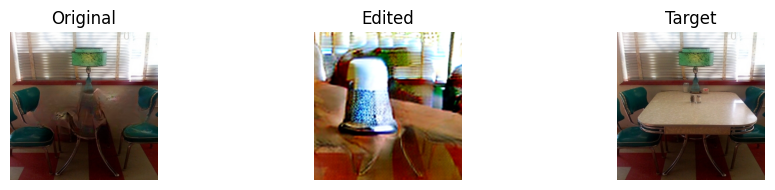

100%|██████████| 100/100 [00:04<00:00, 23.35it/s]


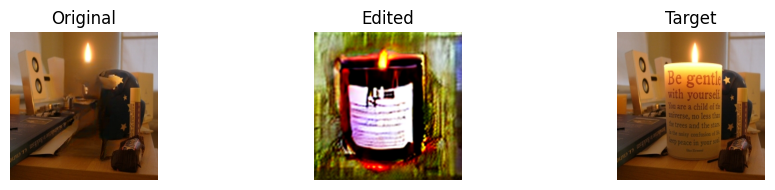

100%|██████████| 100/100 [00:04<00:00, 23.96it/s]


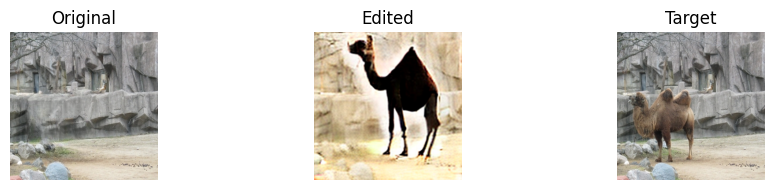

Running inference with num_inference_steps=100, image_guidance_scale=5, guidance_scale=15


100%|██████████| 100/100 [00:04<00:00, 23.06it/s]


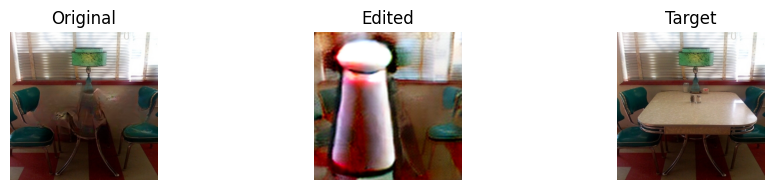

100%|██████████| 100/100 [00:04<00:00, 22.77it/s]


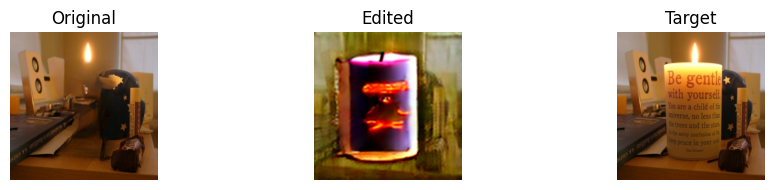

100%|██████████| 100/100 [00:04<00:00, 21.16it/s]


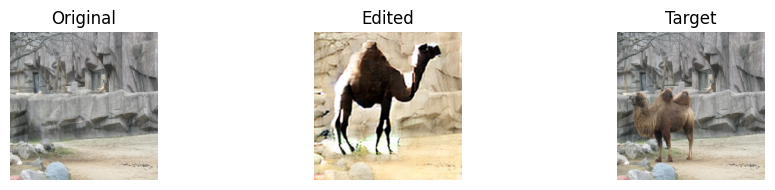

In [47]:
#(50, 2, 20), 
configs = [(100, 4, 20), (100, 5, 15)]

for num_inference_steps, image_guidance_scale, guidance_scale in configs:
    print(f"Running inference with num_inference_steps={num_inference_steps}, image_guidance_scale={image_guidance_scale}, guidance_scale={guidance_scale}")
    run_inference(num_inference_steps, image_guidance_scale, guidance_scale)


In [49]:
from tqdm import tqdm
def run_all_inference(num_inference_steps, image_guidance_scale, guidance_scale):
    for i, sample in enumerate(tqdm(dataset)):
        image = load_image(sample["original_image"])
        prompt = sample["edit_instruction"]
        target = load_image(sample["edited_image"])
        
        edited_image = pipeline(
            prompt,
            image=image,
            num_inference_steps=num_inference_steps,
            image_guidance_scale=image_guidance_scale,
            guidance_scale=guidance_scale,
            generator=generator,
        ).images[0]
        
        # Save output
        os.makedirs(f"results/{i}", exist_ok=True)
        image.save(f"results/{i}/original.png")
        with open(f"results/{i}/prompt.txt", "w") as f:
            f.write(prompt)
        edited_image.save(f"results/{i}/edited.png")
        target.save(f"results/{i}/target.png")

In [50]:
run_all_inference(100, 4, 20)

100%|██████████| 118/118 [09:08<00:00,  4.65s/it]
